# 3D Convolutional autoencoder for voxel data!

 This code shows the example of a 3D convolution autoencoder applied on ModelNet40 and PSB datasets.
 It is the natural extension of [Part 1](./2d_autoencoder.ipynb) of this series.

 These links complement the ones introduced in Part 1:
 - https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/tree/master/Generative
 - https://github.com/AnTao97/PointCloudDatasets/blob/master/dataset.py

 ## Background
 This part of the series needs a bit more explanation. So far, there haven't been many attempts to use CNN's for 3D objects. Why? Probably because of the representation that would be required for a vanilla CNN to work without many changes.
 ### Pixels and Voxels
 The logical 3D extenstion of a 2D image would be a 3D grid, because an image is essentially a 2D grid with each cell representing a pixel. In the same manner 3D cells in a 3D grid are called voxels. In both cases, pixels and voxels are somewhat abstract containers that hold values. We typically think pixels strictly contain only color values but they can hold much more information. Opacity is an intuitive example, but we could even save meta-data in there. That was just for the intuition. Voxels are pretty common within neuroscience and obviously game technology.
 ### Voxels and Convolutions
 After this description it might be trivial, but we can extend the intuition about convolutions easily onto the next dimension. While we convolve for with a restricted set of 2D filters over images, we do the same with 3D objects. This time, we only imagine cubes instead of squares. In fact, many of you who have already used CNN's know, that this is already common practice, as we treat colors often as that third dimension. This flexibility ties back to the idea that these cells are merely containers and the dimensions can represent anything.
 ### So far so good... But what's the issue with those?
 Well, neither am I well acquainted with Game-Technology nor do I have a background in Computer Graphics. However, from what I understand, there are about X reasons:
 - First, voxel data is exponentially larger than pixel data, given the added dimension. Meaning, that you now need to deal with more data and all of it. If you just care about simple singular 3D models, most of the volume might be empty.
 - Second, depending on your resolution (which directly affects the data volume), things can become quite minecrafty.
 - Third, there are alternatives: Point clouds and polygons. Both are vector-based and the ladder even maintains structure.
 ### Why still use voxels then?
 They obviously also have advantages. They maintain structure, they are easy to process in computer graphics, they are great for procedural generation. Some of the algorythms for images like JPEG are easy to extend.
 ### Links
 For more about these matters checkout following materials:
 - [An explanation for voxels imminent comeback in Gaming. May be a bit difficult to follow.](https://medium.com/@EightyLevel/how-voxels-became-the-next-big-thing-4eb9665cd13a)
 - [Best explanation that I found on this topic. Also videogame centric.](https://www.quora.com/What-are-the-pros-and-cons-of-using-voxels-instead-of-polygons)

In [1]:
from datetime import datetime
from enum import auto
import functools
import io
from pyntcloud.structures.voxelgrid import VoxelGrid
import tensorflow as tf
import pickle
import pyvista as pv
from pyntcloud import PyntCloud
from tensorflow.python.keras.backend import dtype
from tensorflow.python.keras.engine.base_layer import Layer
from tqdm import tqdm
import pandas as pd
import glob
import random
import numpy as np
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
import tensorflow.keras.optimizers as opt
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import pathlib
from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib
gpus = tf.config.experimental.list_physical_devices('GPU')
# matplotlib.use('TKAgg')
# tf.config.run_functions_eagerly(True)

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

 I've defined a couple of functions that will be used below.
 Most of them only deal with plotting

In [2]:
def compose(f, g):
    return lambda arg: f(g(arg))


def retrieve_voxel_data(cloud, n=8):
    voxelgrid_id = cloud.add_structure("voxelgrid", n_x=n, n_y=n, n_z=n)
    voxelgrid = cloud.structures[voxelgrid_id]
    vol = np.array(voxelgrid.get_feature_vector(mode="binary"), dtype=np.uint16)
    return vol, voxelgrid


def plot_binary_pointcound(vertex_list):
    vertices = np.argwhere(vertex_list)
    tcloud = PyntCloud(pd.DataFrame(vertices, columns="x y z".split()))
    tcloud.plot(mesh=True, width=400, height=400, backend="threejs")


def generate_img_of_decodings(encodings, decodings, n=5, thresh=.5):
    rows = 2
    fig = plt.figure(figsize=(8, 5))

    for i in range(0, n):
        cnt = i + 1
        ax = fig.add_subplot(rows, n, cnt, projection='3d')
        elem1 = encodings[i]
        ax.voxels(elem1, cmap="Greys_r")
        # encoding_strings = "\n".join([f"{feature:.2f}" for feature in z[i]])
        ax = fig.add_subplot(rows, n, cnt + 1 * n, projection='3d')
        elem2 = decodings[i] >= thresh
        ax.voxels(elem2, cmap="Greys_r")

    return fig


def generate_img_of_decodings_expanded(encodings, decodings, thresholds=[.9, .95, .99, .999, 1]):
    
    rows = 1
    fig = plt.figure(figsize=(25, 5))
    n = len(thresholds) + 1
    encoding_res = len(encodings[0])
    ax = fig.add_subplot(rows, n, 1, projection='3d')
    elem1 = encodings[0].squeeze()
    ax.set_title("Original")
    ax.voxels(elem1, cmap="Greys_r")
    for i, tresh in enumerate(thresholds):
        cnt = i + 1
        ax = fig.add_subplot(rows, n, cnt + 1, projection='3d')
        ax.set_title(f"> {tresh:05.5f}")
        ax.set_xlim(0, encoding_res)
        ax.set_ylim(0, encoding_res)
        ax.set_zlim(0, encoding_res)
        # mask = np.where(decodings[0] >= tresh, 1, np.zeros_like(decodings[0]))
        # masked_elem = mask * decodings[0]
        elem2 = (decodings[0] >= tresh).squeeze()
        ax.voxels(elem2, cmap="Greys_r")

    return fig


def plot_pointcound(pynt_cloud_object, n=32):
    vol, example_voxelgrid = retrieve_voxel_data(pynt_cloud_object, n)
    return example_voxelgrid.plot(d=3, mode="binary", cmap="hsv", width=400, height=400)

def plot_pointcound_matplotlib(pynt_cloud_object, n=32):    
    vol, example_voxelgrid = retrieve_voxel_data(pynt_cloud_object, n)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')  
    ax.voxels(vol)  
    return plt.show()

 ## Data preprocessing
 Because I only have polygon meshes of the data, I decided to opt for a library to convert those to voxel representations.
 The library is called [pyntcloud](https://github.com/daavoo/pyntcloud).

In [3]:
path_to_dataset = pathlib.Path("data/dataset.pkl")
point_cloud_dataset_collected = None
num_meshes = None
if path_to_dataset.exists():
    point_cloud_dataset_collected = pickle.load(io.open(path_to_dataset, "rb"))
    num_meshes = len(point_cloud_dataset_collected)

if not path_to_dataset.exists():
    data_files = list(glob.glob(str("data/**/*.ply"), recursive=True))
    num_meshes = len(data_files)
    point_cloud_dataset_generator = (PyntCloud.from_file(mesh_file) for mesh_file in tqdm(data_files, total=num_meshes))
    point_cloud_dataset_collected = list(point_cloud_dataset_generator)
    pickle.dump(file=io.open(path_to_dataset, "wb"), obj=point_cloud_dataset_collected)
    print(f"Loaded point clouds for {num_meshes} meshes")

 Let's see what we got. I used 32 as a default cell count in all dimensions.
 32 is just an arbitrary number I chose. Obviously, the more the more fine grained the images but the more data to process.

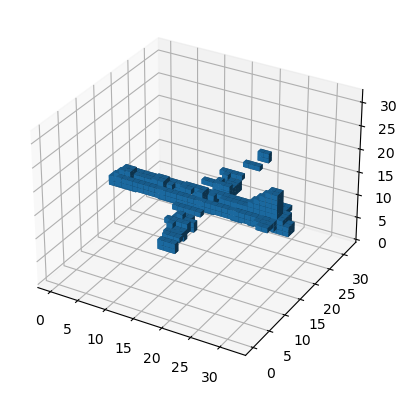

In [4]:
plot_pointcound_matplotlib(point_cloud_dataset_collected[4], 32)

 Let's check out what we retrieve with a lower resolution

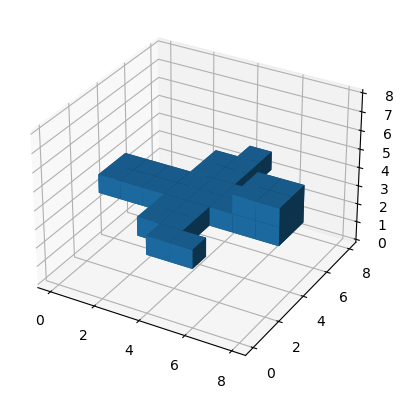

In [5]:
plot_pointcound_matplotlib(point_cloud_dataset_collected[4], 8)

 Now with a higher one

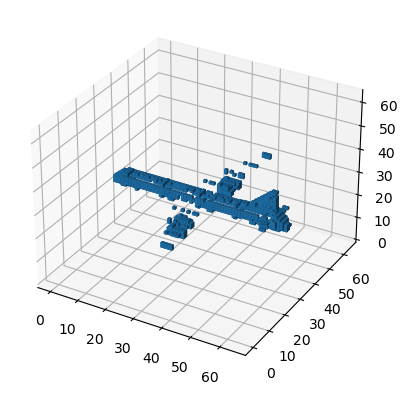

In [6]:
plot_pointcound_matplotlib(point_cloud_dataset_collected[4], 64)

 Here, I convert all voxels to a numpy matrix with dimensions: [N, 32, 32, 32, 1]

 Intuitively you can understand N as number of voxels and the 1 is "like" the color channel for the 2D image case.


In [7]:
path_to_voxel_matrix = pathlib.Path("data/dataset_voxels.npz")
data = None
if path_to_voxel_matrix.exists():
    data = np.load(path_to_voxel_matrix)["data"]

if not path_to_voxel_matrix.exists():
    voxel_data_generator = (retrieve_voxel_data(cloud, 32)
                            for cloud in tqdm(point_cloud_dataset_collected, total=num_meshes))
    voxel_data_collected = list(voxel_data_generator)
    voxel_data = np.array([item[0] for item in voxel_data_collected])
    data = voxel_data.reshape(voxel_data.shape + (1, ))
    np.savez_compressed(path_to_voxel_matrix, data=data)
data_shape = data.shape[1:]
f"Loaded voxel data for {num_meshes} meshes"

'Loaded voxel data for 15693 meshes'

 Why am I adding the test set back to the training set? Autoencoders do not learn a distribution. There are more like efficient data stores. Hence, If you try to reconstruct things that were never seen before, they do not tend to perform well. This is something that the variational counterpart solves. Hence, in order to make sure the model actually can reconstruct the data we have to let it see the data.

In [8]:
cut_point = .1
x_train, x_test = train_test_split(data.astype(np.float), shuffle=True, test_size=.1)
print(f"Initial Training: {x_train.shape} | Test: {x_test.shape}")
x_train = np.concatenate([x_train, x_test])
print(f"Readded test to training: {x_train.shape} | Test: {x_test.shape}")

<ipython-input-8-2d5452b8d0e7>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train, x_test = train_test_split(data.astype(np.float), shuffle=True, test_size=.1)


Initial Training: (14123, 32, 32, 32, 1) | Test: (1570, 32, 32, 32, 1)
Readded test to training: (15693, 32, 32, 32, 1) | Test: (1570, 32, 32, 32, 1)


 ## The model building blocks
 This is where the model starts. To step up the game, I used subclassing to modularized the model and make it seem cleaner.

 I was inspired by following resources
 - https://stackoverflow.com/a/58526969/4162265
 - https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example

 I took most of the conceptual ideas from the paper that inspired this code:
 [Generative and Discriminative Voxel Modeling with Convolutional Neural Networks](http://arxiv.org/abs/1608.04236) by Brock et. al.
 Luckily he provides a quick run down in a [video](https://www.youtube.com/watch?v=LtpU1yBStlU)
 I also took inspiration from his code on [Github](https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling) in order to understand and debug.
 (But this is for rather advanced Python coders as you might not get everything immediately. The code is written in a framework I don't really know called Lasagne. It is based on Theano. So there was little copy pasting here possible.)


 These are just abstractions of the main processing units. The setup is very common.
 A convolution, then a dropout and afterwards normalisation. The order or even whether to use this setup is hotly debated.
 Checkout [https://stackoverflow.com/questions/39691902/ordering-of-batch-normaliazation-and-dropout](this) or [this](https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/)
 I might drop the dropout layer in the future as it seems to have fallen from grace.

In [9]:
WITH_DROP = False


class EncoderUnit(Layer):
    def __init__(self, num_filters, name="encoder_unit", **kwargs) -> None:
        super(EncoderUnit, self).__init__(name=name, **kwargs)
        self.conv = layers.Conv3D(num_filters,
                                  3,
                                  activation='elu',
                                  strides=2,
                                  padding='same',
                                  kernel_regularizer=reg.L1L2(.1, .1))
        self.drop = layers.Dropout(.5)
        self.norm = layers.BatchNormalization()

    def call(self, inputs, **kwargs):
        x = self.conv(inputs)
        if WITH_DROP:
            x = self.drop(x)
        x = self.norm(x)
        return x


class DecoderUnit(Layer):
    def __init__(self, num_filters, name="encoder_unit", **kwargs) -> None:
        super(DecoderUnit, self).__init__(name=name, **kwargs)
        self.conv = layers.Conv3DTranspose(num_filters,
                                           3,
                                           activation="elu",
                                           strides=2,
                                           padding="same",
                                           kernel_regularizer=reg.L1L2(.1, .1))
        self.drop = layers.Dropout(.5)
        self.norm = layers.BatchNormalization()

    def call(self, inputs, **kwargs):
        x = self.conv(inputs)
        if WITH_DROP:
            x = self.drop(x)
        x = self.norm(x)
        return x


class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def __init__(self, output_dim, name="Sampler", **kwargs):
        super(Sampling, self).__init__(name=name, **kwargs)
        self.output_dim = output_dim
        self.flatten = layers.Flatten()
        self.sample = layers.Dense(self.output_dim, kernel_regularizer=reg.L1L2(.1, .1))

    def call(self, inputs):
        x = self.flatten(inputs)
        z = self.sample(x)
        return z

 I will also use a custom loss function. The reason here is, that all that we want is predict whether the cell in question has its voxel filled or not.
 Remember, we only have one color &mdash; grey. And we don't even want anything between this color spectrum. What we want is either black or white. Absolute certainty for any of those.

 This makes our problem a high dimensional binary classification task. Hence, you would use binary-cross-entropy in that case.
 However, there's a catch: Most of our data is probably pretty empty. It would be easy for the model to just predict everything is empty.
 That's called "getting stuck in a local optimum". Pretty unfortunate, if that optimum is a very bad one.

 The solution is weighting correctly predicted cells that are empty less than hitting a filled cell.
 Additionally, I decided to not take the mean of the sum, because this does not produce a large flow of loss back into the model. Or at least that was my intuition.
 The general design for the code was taken from [here](https://stackoverflow.com/questions/61799546/how-to-custom-losses-by-subclass-tf-keras-losses-loss-class-in-tensorflow2-x)

In [10]:
class WeightedBinaryCrossEntropy(tf.keras.losses.Loss):
    """
    Args:
    pos_weight: Scalar to affect the positive labels of the loss function.
    weight: Scalar to affect the entirety of the loss function.
    from_logits: Whether to compute loss from logits or the probability.
    reduction: Type of tf.keras.losses.Reduction to apply to loss.
    name: Name of the loss function.
    """
    def __init__(self,
                 penalty,
                 reduction=tf.keras.losses.Reduction.AUTO,
                 name='weighted_binary_crossentropy'):
        super().__init__(reduction=reduction, name=name)
        self.penalty = penalty

    def call(self, y_true, y_pred):
        return WeightedBinaryCrossEntropy.wbce_paper(y_true, y_pred, self.penalty)[0]
    
    @staticmethod
    def wbce_new(y_true, y_pred, penalty):
        positives = penalty * y_true * tf.math.log(y_pred)
        negatives = (1.0 - penalty) * (1.0 - y_true) * tf.math.log(1.0 - y_pred)
        binary_cross_entropy = - positives - negatives 
        loss = tf.reduce_sum(binary_cross_entropy)
        return loss, binary_cross_entropy

    @staticmethod
    def wbce_paper(y_true, y_pred, penalty):
        y_true_mod = WeightedBinaryCrossEntropy.rebase(y_true, 0,1)
        y_pred_mod = WeightedBinaryCrossEntropy.rebase(y_pred, 0.00001,0.99999)
        positives = penalty * y_true_mod * tf.math.log(y_pred_mod)
        negatives = (1.0 - penalty) * (1.0 - y_true_mod) * tf.math.log(1.0 - y_pred_mod)
        binary_cross_entropy = - positives - negatives 
        loss = tf.reduce_sum(binary_cross_entropy)/tf.cast(len(y_true_mod), tf.float32)
        return loss, binary_cross_entropy

    @staticmethod
    def rebase(x1, min_val, max_val):
        x1 = (x1 * (max_val - min_val)) + min_val
        return x1

 ## Model definitions for encoding and decoding
 The next part introduces the models. I also created a dedicated sampling layer, because I want to expand this approach to variational autoencoders in the future.
 I don't think they are very comlicated to understand, given that I have abtracted the processing units away.

 What's important in the encoder is that I return the last layer which is flattend AND the previous layer which is unflattend.
 With this approach, I can bridge shapes onto the decoder.

In [11]:
class Encoder(Model):
    def __init__(self, data_shape, output_dim=8, EncoderUnit=EncoderUnit, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.data_shape = data_shape
        self.output_dim = output_dim
        self.elayers = [
            EncoderUnit(8),
            EncoderUnit(16),
            EncoderUnit(32),
            EncoderUnit(64),
        ]
        self.sampler = Sampling(self.output_dim)


    def call(self, inputs, **kwargs):
        x = inputs
        for layer in self.elayers:
            x = layer(x)

        z = self.sampler(x)
        return z, x

    def summary(self, line_length=None, positions=None, print_fn=None):
        x = layers.Input(shape=(32, 32, 32, 1))
        print(x)
        encoder = Model(inputs=[x], outputs=self.call(x))
        encoder.summary(line_length=line_length, positions=positions, print_fn=print_fn)

 The decoder, on the other hand, builds two of his layers slightly after initialization. With this I can slightly defer the creation of these layers.
 Why not in the call method then? I tried that, but it seems that TF or Keras does not recognize layers in the call method as trainable layers.
 Hence, you will see a difference in number of training params if you do so nonetheless.

In [12]:
class Decoder(Model):
    def __init__(self, original_shape, input_dim, DecoderUnit=DecoderUnit, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.original_shape = original_shape
        self.input_dim = input_dim
        self.dlayers = [
            DecoderUnit(64),
            DecoderUnit(32),
            DecoderUnit(16),
            DecoderUnit(8),
        ]
        self.final_decoding = layers.Conv3DTranspose(1, 3, activation='sigmoid', strides=1, padding="same")

    def build(self, input_shape):
        self.in_shape = np.prod(input_shape[1][1:])
        print(input_shape)
        self.bridging_shape = input_shape[1][1:]
        self.receiver = layers.Dense(self.in_shape, kernel_regularizer=reg.L1L2(.1, .1))
        self.unflattener = layers.Reshape(self.bridging_shape)

    def call(self, inputs, **kwargs):
        embedding, _ = inputs
        x = self.receiver(embedding)
        x = self.unflattener(x)
        for layer in self.dlayers:
            x = layer(x)
        decoder_outputs = self.final_decoding(x)
        return decoder_outputs

    def summary(self, line_length=None, positions=None, print_fn=None):
        x = layers.Input(shape=(self.input_dim))
        decoder = Model(inputs=[x], outputs=self.call([x, None]))
        decoder.summary(line_length=line_length, positions=positions, print_fn=print_fn)

 Another point is, that both are models on their own, instead of specialized layers.
 There is almost no difference, other than that making a summary of customized layers is quite complicated.
 Most of the model summary will become hidden from you and replace by output shape "multiple".
 However, if encoder and decoder are models themselves, that issue becomes a matter of overwriting the default summary function.

 If you don't get what I mean just switch Encoder(Model) to Encoder(Layer) and you will notice.

 This code brings all together. With all the modularisation from beforehand it should be very straightforward.

In [13]:
class AutoEncoder(Model):
    def __init__(self, data_shape, hidden_dim=300, verbose=False, name="autoencoder", **kwargs):
        super(AutoEncoder, self).__init__(name=name, **kwargs)
        self.original_shape = data_shape
        self.in_shape = (None, ) + self.original_shape
        self.hidden_dim = hidden_dim
        self.encoder = Encoder(self.original_shape, self.hidden_dim)
        self.decoder = Decoder(self.original_shape, self.hidden_dim)

    def call(self, inputs, **kwargs):
        x = layers.InputLayer(self.original_shape)(inputs)
        z, x = self.encoder(x)
        z = layers.InputLayer(self.original_shape)(z)
        decodings = self.decoder([z, x])
        return decodings

    def summary(self, line_length=None, positions=None, print_fn=None):
        self.build((None, ) + self.original_shape)
        # x = layers.Input(shape=(32, 32, 32, 1))
        # encoder = Model(inputs=[x], outputs=self.encoder(x))
        self.encoder.summary(line_length=line_length, positions=positions, print_fn=print_fn)
        self.decoder.summary(line_length=line_length, positions=positions, print_fn=print_fn)
        return super().summary(line_length=line_length, positions=positions, print_fn=print_fn)

 I create a function that rescales the values in the data to a range that I see fit.
 The reason is that Brock et al. found out that that a modification boosts the models performance significantly.
 If you use tensorboard, you can view the output distributions of the predictions.
 They will shows you how the model either predicts one or another value in the decoding phase.
 For more on this, read the paper. It is pretty easy to understand.


In [14]:
def _rebase(x1, x2, min_val, max_val):
    x1 = (x1 * (max_val - min_val)) + min_val
    x2 = (x2 * (max_val - min_val)) + min_val
    return x1, x2

 Hyperparams. This needs no explanation.

In [15]:
penalty = .9
learning_rate = 0.01
comment = "fixed"
batch_size = 5
hidden_dim = 200 
epochs = 50

autoencoder = AutoEncoder(data_shape=data_shape, hidden_dim=hidden_dim, verbose=2)
loss_fn = WeightedBinaryCrossEntropy(penalty=penalty)
# opt_cl = opt.SGD(learning_rate=learning_rate, nesterov=True, momentum=.9)
opt_cl = opt.Adam(learning_rate=learning_rate)

autoencoder.compile(optimizer=opt_cl, loss=loss_fn)
autoencoder.summary()

[TensorShape([None, 200]), TensorShape([None, 2, 2, 2, 64])]
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 32, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 32, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 16, 16, 16, 8)     224       
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 16, 8)    32        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 8, 8, 16)       3472      
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 

 Some minor stuff with regards to tensorboard. This code helped debugging my model.

In [16]:
def construct_log_dir(elements=[]):
    log_dir = f"logs/{datetime.now().strftime('%m%d%H%M%S')}/" + "-".join(elements)
    return log_dir


elems = [
    f"penalty[{penalty:05.5f}]",
    f"lr[{learning_rate:07.7f}]",
    f"batch[{batch_size:02d}]",
    f"dim[{hidden_dim:03d}]",
    f"{comment}" if comment else "NA",
]

log_dir = construct_log_dir(elems)
print(log_dir)


def lr_schedule(epoch):
    """
  Returns a custom learning rate that decreases as epochs progress.
  """
    learning_rate = 0.0001
    if epoch > 5:
        learning_rate = 0.001

    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate


def my_ceil(a, precision=0):
    # https://stackoverflow.com/a/58065394/4162265
    return np.round(a + 0.5 * 10**(-precision), precision)


def my_floor(a, precision=0):
    return np.round(a - 0.5 * 10**(-precision), precision)


class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, penalty=.99, n=5):
        self.x_test, self.y_test = validation_data
        self.n = n
        self.penalty = penalty

    def on_epoch_begin(self, epoch, logs={}):
        # https://stackoverflow.com/questions/51837387/callback-returning-train-and-validation-performance

        test_sample = np.array(random.sample(list(self.x_test), 100))
        val_true = test_sample
        val_predict = np.asarray(self.model.predict(test_sample))
        loss, bce = WeightedBinaryCrossEntropy.wbce_paper(val_true, val_predict, self.penalty)
        min_pred = np.min(val_predict)
        max_pred = np.max(val_predict)
        mean_pred = np.mean(val_predict)
        median_pred = np.median(val_predict)
        minmax_ratio = min_pred / max_pred
        print(f"Min {min_pred:.3f} - Max {max_pred:.3f} - Mean {mean_pred:.3f} - Loss {loss:.3f}")

        fig = generate_img_of_decodings_expanded(val_true, val_predict, [0.5, 0.75, 0.9, 0.95])
        fig.tight_layout()
        fig.savefig('example.png')  # save the figure to file
        plt.close()
        canvas = FigureCanvasAgg(fig)
        canvas.draw()
        buf = canvas.buffer_rgba()
        img = np.asarray(buf, np.uint8)

        tf.summary.histogram("predictions", val_predict, step=epoch)
        tf.summary.scalar("min", min_pred, step=epoch)
        tf.summary.scalar("max", max_pred, step=epoch)
        tf.summary.scalar("mean", mean_pred, step=epoch)
        tf.summary.scalar("median", median_pred, step=epoch)
        tf.summary.scalar("minmax", minmax_ratio, step=epoch)
        tf.summary.histogram("BCE", bce, step=epoch)
        tf.summary.scalar("Loss", loss, step=epoch)
        tf.summary.image(f"After epoch: {epoch}", img.reshape(-1, *img.shape), step=epoch)
        tf.summary.flush()


file_writer = tf.summary.create_file_writer(log_dir)
file_writer.set_as_default()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

validation_data = (x_test, x_test)
image_log_callback = CustomCallback(validation_data, penalty=penalty)

logs/1120105202/penalty[0.90000]-lr[0.0100000]-batch[05]-dim[200]-fixed


In [17]:
# Alright let's go!
history = autoencoder.fit(
    x_train,
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=validation_data,
    callbacks=[
        image_log_callback,
        # lr_callback,
        # tensorboard_callback,
    ])

4/4 [==============================] - 1s 107ms/step
Min 0.498 - Max 0.502 - Mean 0.500 - Loss 3174.614
Epoch 1/50
4/4 [==============================] - 1s 146ms/step
Min 0.000 - Max 0.964 - Mean 0.120 - Loss 1404.047
Epoch 2/50
4/4 [==============================] - 1s 147ms/step
Min 0.000 - Max 0.977 - Mean 0.128 - Loss 1294.053
Epoch 3/50
4/4 [==============================] - 1s 163ms/step
Min 0.000 - Max 0.971 - Mean 0.121 - Loss 1184.655
Epoch 4/50
4/4 [==============================] - 1s 146ms/step
Min 0.000 - Max 0.954 - Mean 0.110 - Loss 1237.183
Epoch 5/50
4/4 [==============================] - 1s 148ms/step
Min 0.000 - Max 0.960 - Mean 0.186 - Loss 1228.236
Epoch 6/50
4/4 [==============================] - 1s 153ms/step
Min 0.000 - Max 0.988 - Mean 0.131 - Loss 1250.609
Epoch 7/50
4/4 [==============================] - 1s 147ms/step
Min 0.000 - Max 0.971 - Mean 0.162 - Loss 1226.163
Epoch 8/50
4/4 [==============================] - 1s 136ms/step
Min 0.000 - Max 0.959 - Mea

 Let's save the model, so that we can reuse it.

In [18]:
autoencoder.save("models/3d_autoencoder.tfmodel", save_format="tf")

INFO:tensorflow:Assets written to: models/3d_autoencoder.tfmodel\assets


INFO:tensorflow:Assets written to: models/3d_autoencoder.tfmodel\assets


 Here, I am loading the model again.

In [19]:
autoencoder_loaded = None
mpath = pathlib.Path("models/3d_autoencoder.tfmodel")
if mpath.exists():
    autoencoder_loaded = tf.keras.models.load_model(mpath,
                                             compile=False,
                                             custom_objects={
                                                 'WeightedBinaryCrossEntropy': WeightedBinaryCrossEntropy(penalty),
                                                 'penalty': penalty
                                             })

 I am executing the saved model on 5 samples. First, I generate z.

In [20]:
n = 5
test_sample = np.array(random.sample(list(x_train), n))
z = autoencoder_loaded.encoder.predict(test_sample)
f"Received two arrays"

1/1 [==============================] - 0s 224ms/step


'Received two arrays'

 With z, I can decode the original values.

In [21]:
originals = test_sample.reshape(test_sample.shape[:-1])
decodings = autoencoder_loaded.decoder([tf.convert_to_tensor(z[0]), tf.convert_to_tensor(z[1])]).numpy().reshape(test_sample.shape[:-1])

 This results in the following decodings

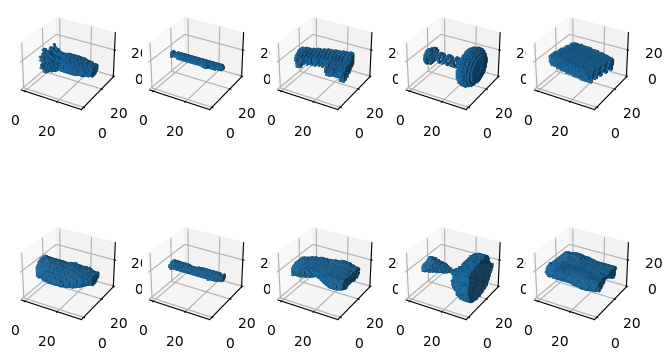

In [22]:
generate_img_of_decodings(originals, decodings, thresh=.5)
plt.show()

1/1 [==============================] - 0s 60ms/step


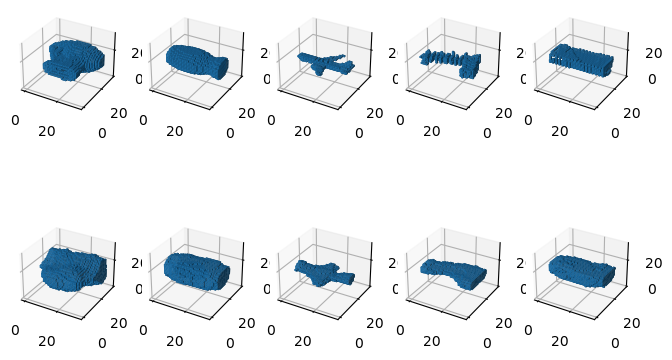

In [23]:
n = 5
test_sample = np.array(random.sample(list(x_train), n))
z = autoencoder_loaded.encoder.predict(test_sample)
originals = test_sample.reshape(test_sample.shape[:-1])
decodings = autoencoder_loaded.decoder([tf.convert_to_tensor(z[0]), tf.convert_to_tensor(z[1])]).numpy().reshape(test_sample.shape[:-1])
generate_img_of_decodings(originals, decodings, thresh=.5)
plt.show()

1/1 [==============================] - 0s 56ms/step


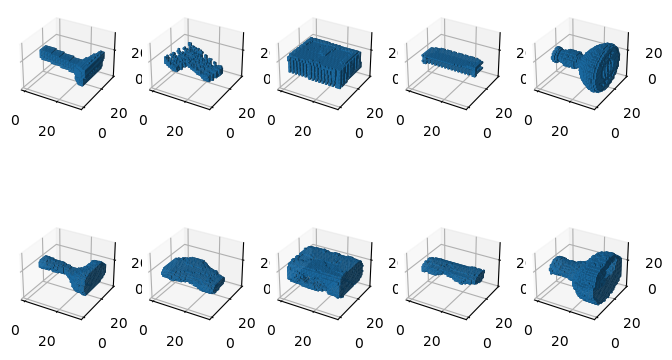

In [24]:
n = 5
test_sample = np.array(random.sample(list(x_train), n))
z = autoencoder_loaded.encoder.predict(test_sample)
originals = test_sample.reshape(test_sample.shape[:-1])
decodings = autoencoder_loaded.decoder([tf.convert_to_tensor(z[0]), tf.convert_to_tensor(z[1])]).numpy().reshape(test_sample.shape[:-1])
generate_img_of_decodings(originals, decodings, thresh=.5)
plt.show()

1/1 [==============================] - 0s 64ms/step


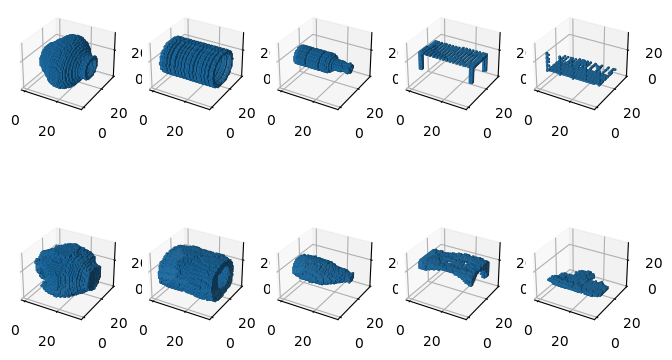

In [27]:
n = 5
test_sample = np.array(random.sample(list(x_train), n))
z = autoencoder_loaded.encoder.predict(test_sample)
originals = test_sample.reshape(test_sample.shape[:-1])
decodings = autoencoder_loaded.decoder([tf.convert_to_tensor(z[0]), tf.convert_to_tensor(z[1])]).numpy().reshape(test_sample.shape[:-1])
generate_img_of_decodings(originals, decodings, thresh=.5)
plt.show()